In [2]:
import os
import sys
import numpy as np 
sys.path.append('./')

from encoder import ConformerEncoder, ConformerBlock

import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [16]:
# Dataset setup
class TimbreDataset(Dataset):
    def __init__(self, root_dir, instrument_to_label, sample_rate=44100, duration_ms=500, n_mels=128):
        self.samples = []
        self.labels = []
        self.sr = sample_rate
        self.clip_len = int(sample_rate * duration_ms / 1000)
        self.n_mels = n_mels
        self.instrument_to_label = instrument_to_label
         
        # preprocess
        for instrument, label in instrument_to_label.items():
            print(f"Preprocessing {instrument} data with label {label}:")
            inst_dir = os.path.join(root_dir, instrument)

            count_1 = 0 # counter for visualization purposes
            count_2 = 0
            count_3 = 0

            if not os.path.isdir(inst_dir):
                continue  # Skip if not a valid directory
            for file in os.listdir(inst_dir):
            # for file in sorted(os.listdir(inst_dir)):
                # print(file)
                if file.endswith('.wav'):
                    file_path = os.path.join(inst_dir, file)

                    try:
                        # Attempt to load the file
                        y, _ = librosa.load(file_path, sr=self.sr)

                        y_trim, _ = librosa.effects.trim(y, top_db=30) # removing anything below 30 dB

                        # plot full waveforms
                        if count_2 < 1:
                            duration = len(y_trim) / self.sr
                            time = np.linspace(0, duration, len(y_trim))

                            plt.figure(figsize=(14, 5))
                            plt.plot(time, y_trim)
                            plt.title(f"Full Waveform of {file}")
                            plt.xlabel("Time (seconds)")
                            plt.ylabel("Amplitude")
                            plt.show()

                            count_2 += 1

                        clip = y_trim[:self.clip_len]
                        if len(clip) < self.clip_len:
                            clip = np.pad(clip, (0, self.clip_len - len(clip)))
                        mel = librosa.feature.melspectrogram(y=clip, sr=self.sr, n_mels=self.n_mels)
                        log_mel = librosa.power_to_db(mel, ref=np.max)

                        # plot full mel spectrograms
                        if count_3 < 1:
                            full_mel = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels)
                            full_log_mel = librosa.power_to_db(full_mel, ref=np.max)
                            duration = len(y) / self.sr
                            time = np.linspace(0, duration, full_mel.shape[-1])

                            plt.figure(figsize=(8, 5))
                            librosa.display.specshow(full_log_mel, y_axis='mel', x_axis='time', sr=self.sr)
                            plt.title(f"Full Log Mel Spectrogram of {file}")
                            plt.xlabel("Time (seconds)")
                            plt.ylabel("Frequency (Mel)")
                            plt.colorbar(format='%+2.0f dB')
                            plt.show()

                            count_3 += 1
                
                        # Ensure the time axis is fixed length
                        target_frames = 50
                        if log_mel.shape[1] < target_frames:
                            pad_width = target_frames - log_mel.shape[1]
                            log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode='constant')
                        else:
                            log_mel = log_mel[:, :target_frames]

                        # self.samples.append(file_path)
                        self.samples.append(log_mel)
                        self.labels.append(label)
                    except Exception as e:
                        # Log the issue and skip the corrupted file
                        print(f"[Error] Skipping {file_path}: {e}")
                        continue  # Skip this file and continue with the rest

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Fetch preprocessed mel spectrogram and corresponding label
        log_mel = self.samples[idx]
        label = self.labels[idx]

        # Return the preprocessed data and label
        return torch.tensor(log_mel, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)

        # file_path = self.samples[idx]
        # label = self.labels[idx]
        # try:
        #     y, _ = librosa.load(file_path, sr=self.sr)
        #     y_trim, _ = librosa.effects.trim(y, top_db=30)
        #     clip = y_trim[:self.clip_len]
        #     if len(clip) < self.clip_len:
        #         clip = np.pad(clip, (0, self.clip_len - len(clip)))
        #     mel = librosa.feature.melspectrogram(y=clip, sr=self.sr, n_mels=self.n_mels)
        #     log_mel = librosa.power_to_db(mel, ref=np.max)
            
        #     # Ensure the time axis is fixed length
        #     target_frames = 22  # whatever size you want
        #     if log_mel.shape[1] < target_frames:
        #         pad_width = target_frames - log_mel.shape[1]
        #         log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode='constant')
        #     else:
        #         log_mel = log_mel[:, :target_frames]

        #     return torch.tensor(log_mel, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)
        # except Exception as e:
        #     print(f"[Error] Skipping {file_path}: {e}")
        #     raise e

{'pia': 0, 'vio': 1, 'voi': 2}
Preprocessing pia data with label 0:


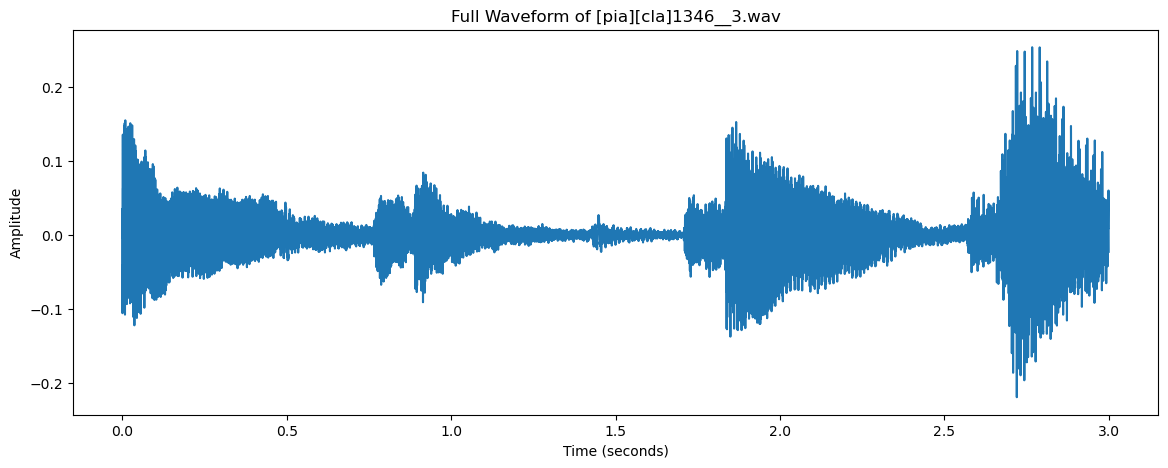

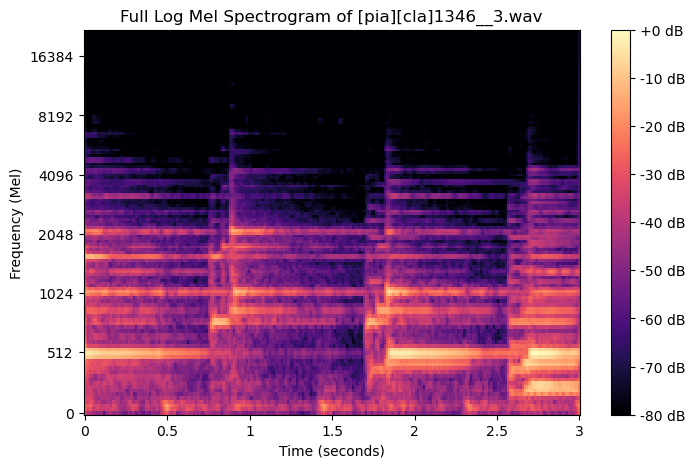

Preprocessing vio data with label 1:


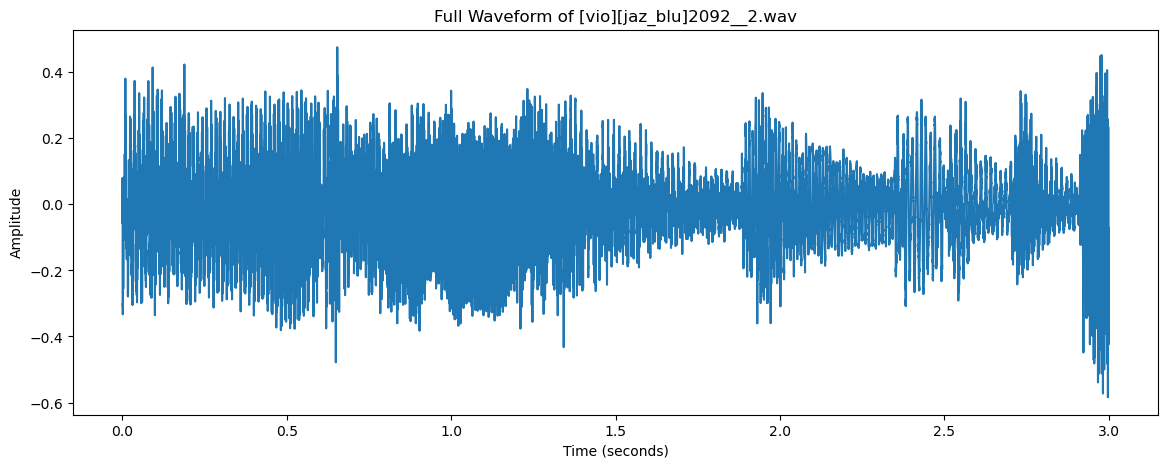

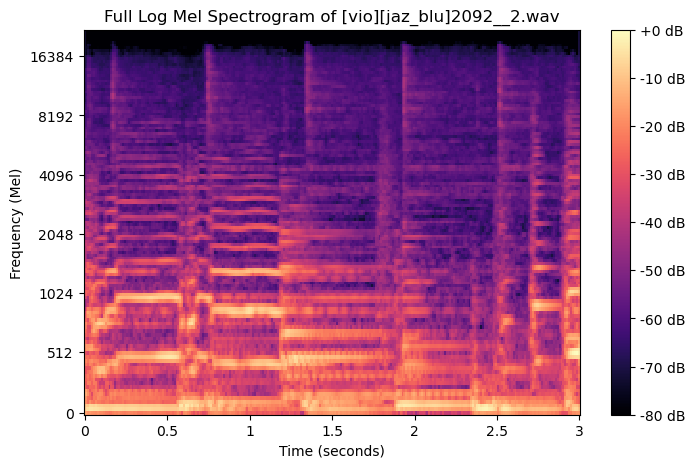

Preprocessing voi data with label 2:


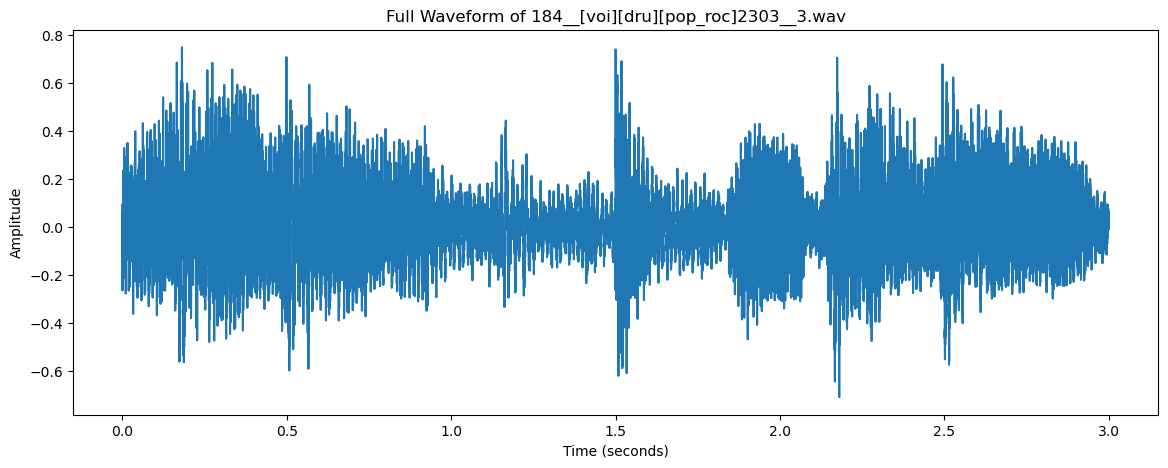

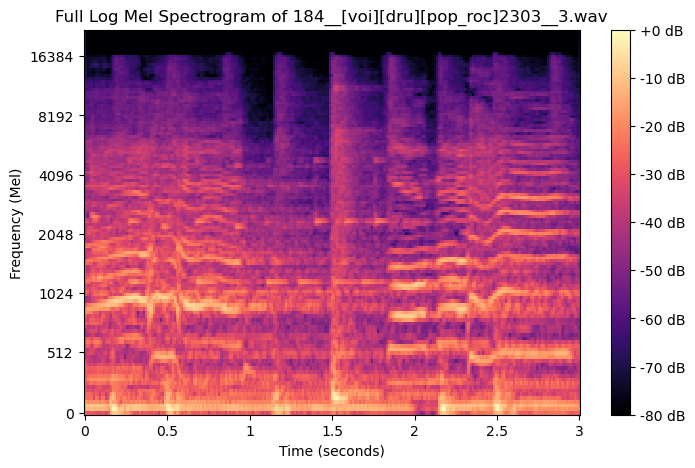

Training Set Counts: Counter({2: 543, 0: 509, 1: 403})
Validation Set Counts: Counter({2: 81, 0: 67, 1: 59})
Test Set Counts: Counter({2: 154, 0: 145, 1: 118})


In [17]:
# Class mapping
classes = ["pia", "vio", "voi"] 
# classes = ['violin', 'viola', 'cello', 'double bass', 'clarinet', 'bass clarinet', 'saxophone', 'flute',
#            'oboe', 'bassoon', 'contrabassoon', 'cor anglais', 'french horn', 'trombone', 'trumpet', 'tuba',
#             'guitar', 'mandolin', 'banjo', 'percussion']
n_classes = len(classes)
instrument_to_label = {name: idx for idx, name in enumerate(classes)}
print(instrument_to_label)

# Splitting
dataset = TimbreDataset("data/irmas", instrument_to_label)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)

# Visualize split to make sure it's as expected
train_labels = [int(label) for _, label in train_ds]
val_labels = [int(label) for _, label in val_ds]
test_labels = [int(label) for _, label in test_ds]

# Count them
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

print("Training Set Counts:", train_counts)
print("Validation Set Counts:", val_counts)
print("Test Set Counts:", test_counts)

In [18]:
# Model definition
class ConformerClassifier(nn.Module):
    def __init__(self, input_dim=128, num_classes=n_classes, num_blocks=4, hidden_dim=144, num_heads=4, dropout=0.1):
        super(ConformerClassifier, self).__init__()
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, kernel_size=1)
        self.conformer_blocks = nn.Sequential(*[
            ConformerBlock(
                encoder_dim=hidden_dim,
                num_attention_heads=num_heads,
                feed_forward_expansion_factor=4,
                conv_expansion_factor=2,
                feed_forward_dropout_p=dropout,
                attention_dropout_p=dropout,
                conv_dropout_p=dropout,
                conv_kernel_size=31,
                half_step_residual=True
            ) for _ in range(num_blocks)
        ])
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.squeeze(1)  # From (B, 1, F, T) to (B, F, T)
        x = self.input_proj(x)  # (B, hidden_dim, T)
        x = x.transpose(1, 2)   # (B, T, hidden_dim) for conformer
        x = self.conformer_blocks(x)
        x = x.transpose(1, 2)   # Back to (B, hidden_dim, T)
        x = self.pooling(x).squeeze(-1)  # (B, hidden_dim)
        return self.classifier(x)

In [19]:
# Device + model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConformerClassifier(input_dim=128, num_classes=len(classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(5):  # Fewer epochs for initial testing
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.8966
Epoch 2, Loss: 0.8052
Epoch 3, Loss: 0.7282
Epoch 4, Loss: 0.6866
Epoch 5, Loss: 0.6577



Precision: 0.784, Recall: 0.687, F1 Score: 0.673, Accuracy: 0.720


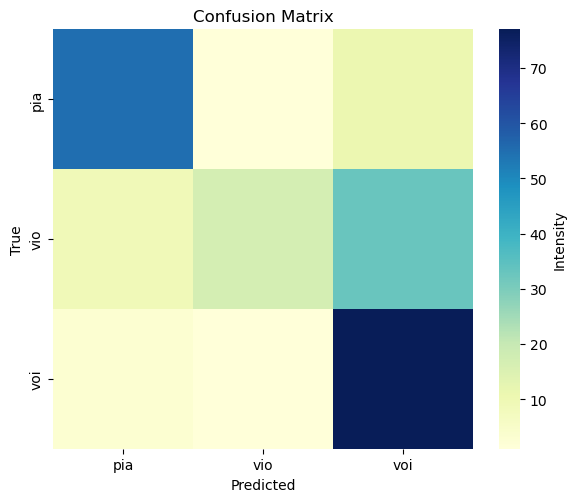

In [20]:
# Evaluation on validation set
model.eval()
all_preds = []
all_targets = []
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        try:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)
            pred_labels = torch.argmax(preds, dim=1)
            all_preds.extend(pred_labels.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

            # Calculate correct predictions and total predictions for accuracy
            correct_predictions += (pred_labels == y_batch).sum().item()
            total_predictions += y_batch.size(0)

        except Exception as e:
            print(f"[Skipping batch due to error]: {e}")
            continue

# Save model for interpretability analysis
model_path = "models/conformer_classifier_irmas.pth"
torch.save(model.state_dict(), model_path)

if len(all_targets) > 0 and len(all_preds) > 0:
    # evaluation metrics
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    accuracy = correct_predictions / total_predictions
    print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, Accuracy: {accuracy:.3f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, fmt="d", cmap="YlGnBu", xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Intensity'}, square=True)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("[Warning] No predictions made — confusion matrix cannot be computed.")

## Interpretability Analysis

In [ ]:
# load in model
model_path = "models/conformer_classifier.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConformerClassifier(input_dim=128, num_classes=len(classes)).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

for name, module in model.named_modules():
    print(name)

attention_layer = model.conformer_blocks[0].sequential[1].module.attention
print(vars(attention_layer))


input_proj
conformer_blocks
conformer_blocks.0
conformer_blocks.0.sequential
conformer_blocks.0.sequential.0
conformer_blocks.0.sequential.0.module
conformer_blocks.0.sequential.0.module.sequential
conformer_blocks.0.sequential.0.module.sequential.0
conformer_blocks.0.sequential.0.module.sequential.1
conformer_blocks.0.sequential.0.module.sequential.1.linear
conformer_blocks.0.sequential.0.module.sequential.2
conformer_blocks.0.sequential.0.module.sequential.3
conformer_blocks.0.sequential.0.module.sequential.4
conformer_blocks.0.sequential.0.module.sequential.4.linear
conformer_blocks.0.sequential.0.module.sequential.5
conformer_blocks.0.sequential.1
conformer_blocks.0.sequential.1.module
conformer_blocks.0.sequential.1.module.positional_encoding
conformer_blocks.0.sequential.1.module.layer_norm
conformer_blocks.0.sequential.1.module.attention
conformer_blocks.0.sequential.1.module.attention.query_proj
conformer_blocks.0.sequential.1.module.attention.query_proj.linear
conformer_block

In [88]:
def visualize_attention_weights(model, input_data, attention_layer_name, num_heads=4):
    """
    Visualizes attention weights from a given attention layer in the Conformer block.
    
    Args:
        model (nn.Module): Trained model with multi-head attention layers.
        input_data (Tensor): The input data (e.g., log-mel spectrogram) to visualize.
        attention_layer_name (str): The name of the attention layer to extract attention weights from.
        num_heads (int): The number of attention heads in the layer.
        
    Returns:
        None (plots the attention heatmap).
    """
    # Set the model to evaluation mode and disable gradient calculation
    model.eval()
    with torch.no_grad():
        # Pass the input through the model to get attention weights
        attention_weights = model(input_data)[attention_layer_name]

        # Visualize attention weights for each attention head
        for i in range(num_heads):
            plt.figure(figsize=(8, 6))
            sns.heatmap(attention_weights[i].cpu().detach().numpy(), cmap='YlGnBu', xticklabels=range(input_data.size(1)),
                        yticklabels=range(input_data.size(1)))
            plt.title(f"Attention Weights - Head {i+1}")
            plt.xlabel("Input Sequence (Time)")
            plt.ylabel("Output Sequence (Time)")
            plt.show()

# print(dataset.samples[0])
logmel = dataset.samples[0]
input_data = torch.tensor(logmel)  # Replace with the log-mel spectrogram from your input
visualize_attention_weights(model, input_data, "conformer_blocks.0.sequential.1.module.attention")

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)